In [1]:
import os
import torch
import torchvision

from torchvision.io import read_image

from ShapeDataset import *
from implementations import *

In [2]:
##### Defining some variables #####
num_classes = 3 + 1  # classes + background
classes = ['Background', 'Cube', 'Octahedron', 'Sphere']
hidden_layer = 128
num_epochs = 100
root = './'
data_dir = os.path.join(root,'Data')
model_savename = f'model_epochs-{num_epochs}_hiddenlayer-{hidden_layer}'

In [3]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

### Defining our model ###
def get_model_instance_segmentation(num_classes, hidden_layer):
    # load an instance segmentation model pre-trained on the COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features # get number of input features for the classifier
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)# replace the pre-trained head with a new one

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # get the number of input features for the mask classifier
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

Let’s now write the main function which performs the training and the
validation:



In [4]:
import utils
from engine import train_one_epoch, evaluate

# train on the GPU if available, if not on the CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations to create datasets
dataset      = torchvision.datasets.wrap_dataset_for_transforms_v2(ShapeDataset(os.path.join(data_dir,'train'),os.path.join(data_dir,'train/_annotations.coco.json'), get_transform(train=True)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])
dataset_test = torchvision.datasets.wrap_dataset_for_transforms_v2(ShapeDataset(os.path.join(data_dir,'test'),os.path.join(data_dir,'test/_annotations.coco.json'), get_transform(train=False)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])

## split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#split_ind = len(dataset)//10
#dataset = torch.utils.data.Subset(dataset, indices[:-split_ind]) 
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-split_ind:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes, hidden_layer)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Model finished training.")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch: [0]  [ 0/47]  eta: 0:05:54  lr: 0.000114  loss: 10.0023 (10.0023)  loss_classifier: 1.2782 (1.2782)  loss_box_reg: 0.4469 (0.4469)  loss_mask: 2.0384 (2.0384)  loss_objectness: 5.9265 (5.9265)  loss_rpn_box_reg: 0.3123 (0.3123)  time: 7.5458  data: 0.0628
Epoch: [0]  [10/47]  eta: 0:04:13  lr: 0.001199  loss: 3.5975 (5.2771)  loss_classifier: 1.1626 (1.0903)  loss_box_reg: 0.6518 (0.6460)  loss_mask: 1.4629 (1.4779)  loss_objectness: 0.8752 (1.9105)  loss_rpn_box_reg: 0.1569 (0.1524)  time: 6.8565  data: 0.0413
Epoch: [0]  [20/47]  eta: 0:03:00  lr: 0.002285  loss: 3.0074 (4.0071)  loss_classifier: 0.8827 (0.9607)  loss_box_reg: 0.5861 (0.5970)  loss_mask: 0.7115 (1.0832)  loss_objectness: 0.5221 (1.2149)  loss_rpn_box_reg: 0.1232 (0.1513)  time: 6.6504  data: 0.0391
Epoch: [0]  [30/47]  eta: 0:01:51  lr: 0.003371  

/Users/johannes/Documents/Uni/Semester7/MachineLearning/ml-project-2-andersmaxjohannes/engine.py:79: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Test:  [0/4]  eta: 0:00:03  model_time: 0.8169 (0.8169)  evaluator_time: 0.0426 (0.0426)  time: 0.8697  data: 0.0102
Test:  [3/4]  eta: 0:00:00  model_time: 0.8074 (0.8126)  evaluator_time: 0.0294 (0.0484)  time: 0.8722  data: 0.0103
Test: Total time: 0:00:03 (0.8723 s / it)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

In [7]:
torch.save(model,model_savename) # Saving the model to modelsave

The number of detected instances of each shape in the selected image are:
Cube:0
Octahedron:0
Sphere:84


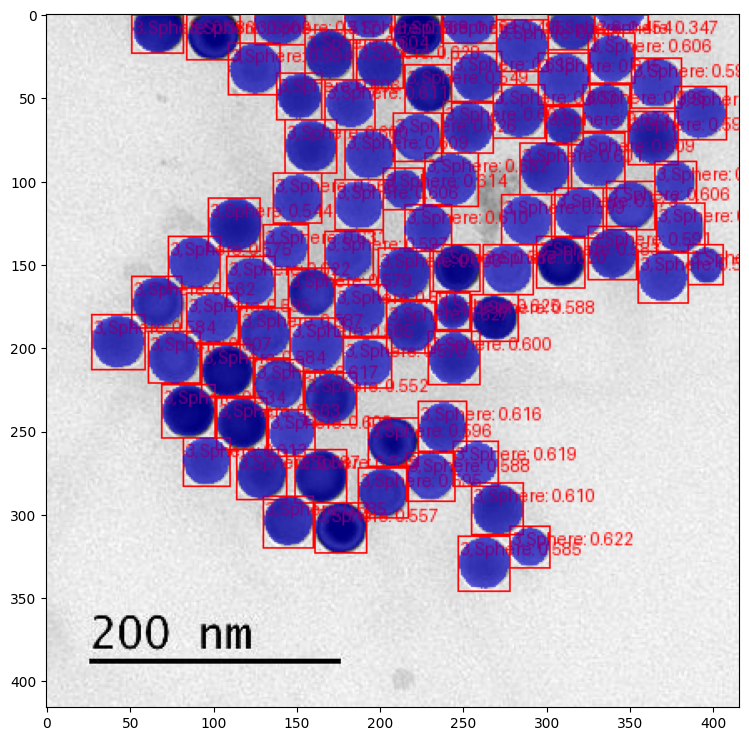

In [56]:
throwaway = predict(model,os.path.join(data_dir,"test/Picture_0_png.rf.8713ba5aa9a3b4a4a74a8e5e55862486.jpg"), classes, box_thresh=0.2, printout=True, show_img=True, img_savefile='PredSpheres')

The number of detected instances of each shape in the selected image are:
Cube:72
Octahedron:2
Sphere:13


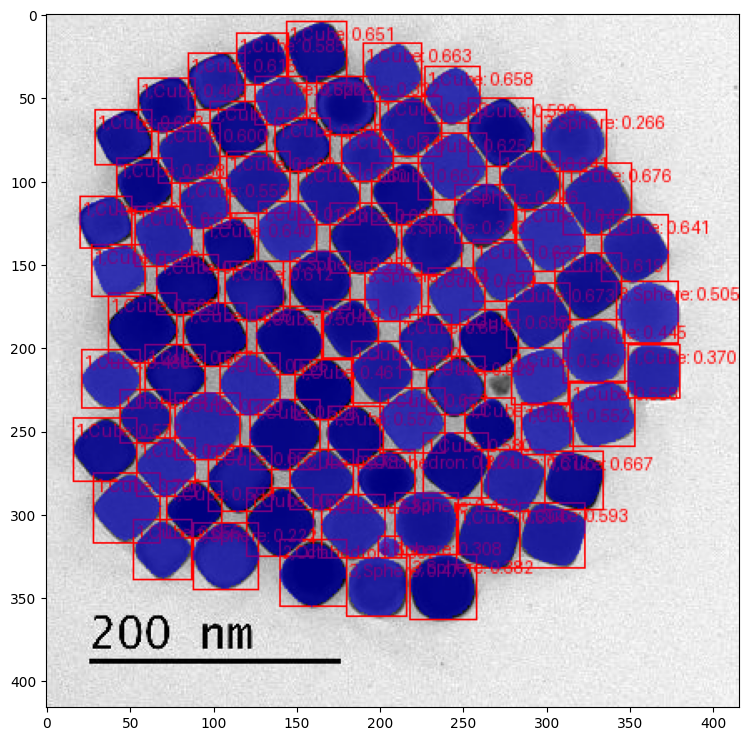

In [57]:
throwaway = predict(model,os.path.join(data_dir,"test/AB-Cu-S2_0008_png.rf.81632644dc4817a25d01583c18cd26f2.jpg"), classes, printout=True, show_img=True, img_savefile='PredMixed')

The number of detected instances of each shape in the selected image are:
Cube:2
Octahedron:51
Sphere:14


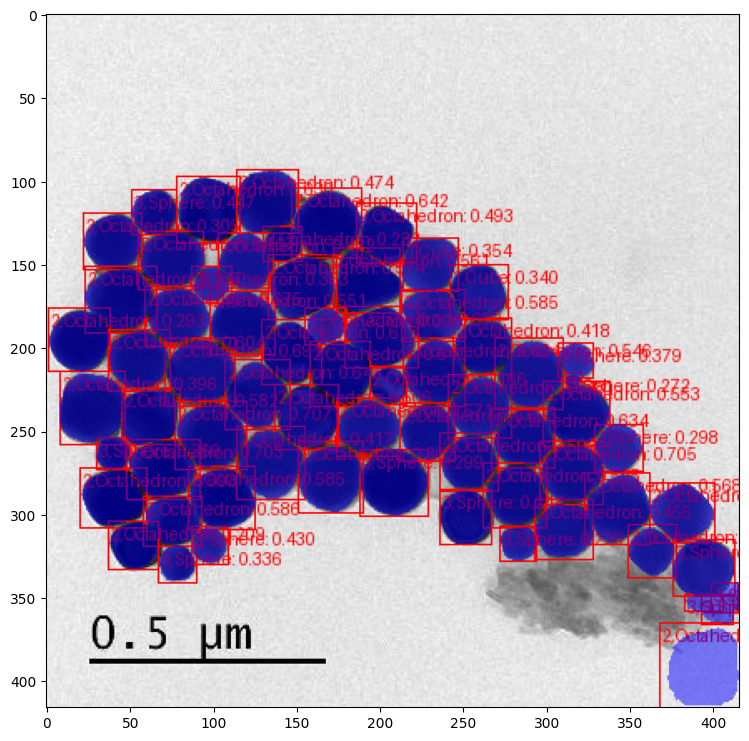

In [58]:
throwaway = predict(model,os.path.join(data_dir,"test/LZCu52_0022_jpg.rf.6f5125e8da8e2faa7385f59724d34626.jpg"), classes, printout=True, show_img=True, img_savefile='PredOcta')

The number of detected instances of each shape in the selected image are:
Cube:6
Octahedron:0
Sphere:0


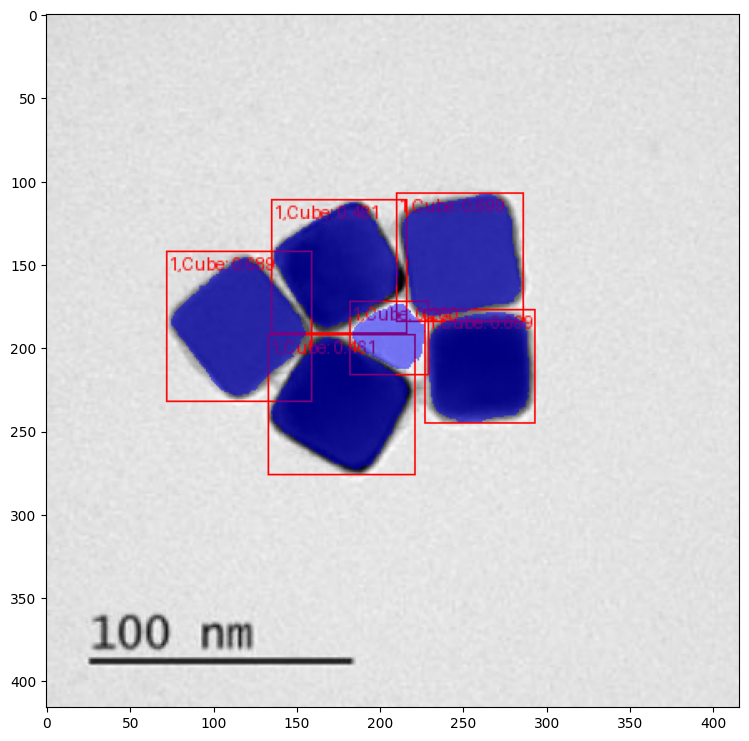

In [59]:
throwaway = predict(model,os.path.join(data_dir,"test/Picture45_png.rf.f868ab2ccf15b48974c00e33bc0f85df.jpg"), classes, box_thresh=0.2, printout=True, show_img=True, img_savefile='PredThreeCubesWithNms')